![Wind Energy Banner](img/1.png)

# Wind Energy Analysis


suggested project: analyze wind speed around the country with a view to a wind farm


![Banner no 2](img/2.png)

## Project Plan

__Research wind farms in Ireland__

- where are they usually located?
- what wind conditions do they need? any other site considerations? Rural locations.
- how much electricity do they generate? summer vs winter?
- cost?
- anything else?

__Project questions__

What's the relationship between wind speed and power generated? Does the wind direction affect power generation? NO 

Is there a trend in wind speed? DONE Is Ireland getting winder? DONE Variations across the year? DONE Time of day?

Is the technology in wind turbines improving? Is more electricity being generated for the same wind speed?

Does rain/temperature/anything affect the output? Relative humidity

What happens during a storm? Does amount of wind generated electricity decrease/increase?

Predict power output for wind farms in Ireland for the next week. Tricky


Is there much variation in wind across the country? EirGrid data for entire country. 

## Introduction

Since the first commercial wind farm opened at Bellacorrick, Co Mayo in 1992 the capacity of wind farms in Ireland has increased significantly. There are now over 300 wind farms in the Republic of Ireland producing 4780 MW of energy each year with 568 MW in construction. In 2000, the [capacity was only 116.5 MW](https://cms.eirgrid.ie/sites/default/files/publications/Wind-Installed-Capacities-May-24.png). Ireland’s largest wind farm is the Galway Wind Park in Connemara. Each turbine in the wind park can generate 3 MW of electricity to give a total capacity of 192 MW. County Kerry wind farms, with a capacity of 746 MW, produced more wind energy that any other county (1664 GWh in 2023). Three counties in Ireland have no wind farms, Co. Kildare, Co. Longford and Co. Westmeath. https://www.windenergyireland.com/about-wind/wind-energy-by-county

![Wind Farms](img/Wind_farms_SEAI.png)

_Credit [SEAI Wind Atlas](https://www.seai.ie/renewable-energy/wind-energy/wind-atlas-map)_

Wind farms are located in windy sites far away from houses and trees. It is important that is is accessible by lorries during construction. https://www.teagasc.ie/rural-economy/rural-development/diversification/wind-energy/ Some considerations for site suitability are 
is the site windy? exposed and distant from trees and buildings? Is the site away from houses? Can lorries access the site for construction? Is the area a protected habitat? Is the area of landscape significant? Is there a high voltage grid connection nearby and if so, is there capacity on the line for new generation?  __MORE RESEARCH__

Increasing the amount of electricity produced from renewable sources is one of the aims of [Ireland’s Climate Action Plan](https://www.gov.ie/pdf/?file=https://assets.gov.ie/296414/7a06bae1-4c1c-4cdc-ac36-978e3119362e.pdf#page=null). It is hoped that by 2030, 80% of Ireland's electricity will be produced from renewable sources, of which 9000 MW should come from onshore wind energy. According to the [SEAI](https://www.seai.ie/data-and-insights/seai-statistics/renewables), currently ~ 40% of Ireland’s electricity is from renewable sources, with one third from wind energy. In contrast, in 2023, solar-PV generation accounted for 1.9% of electricity supply which is the equivalent of providing all the country's electricity needs for 1 full week. 

The amount of electricity a turbine generates depends on the type of turbine and the wind conditions at any time. According to the most recent information available for 2019 - 2022, from [Orsted, a wind energy company with a number of wind farms in Ireland](https://orsted.ie/renewable-energy-solutions/onshore-wind/onshore-wind-facts/is-onshore-wind-power-reliable?gad_source=1&gclid=Cj0KCQiAvbm7BhC5ARIsAFjwNHsqQo_o5BNQDDSs188yJNVjuNKutenLgB4fyrrApMoVsbYHk8igaZUaAk-YEALw_wcB), 91% of the time there is enough wind for production. 1% of time there is too much wind, 8% too little wind. Older turbines are less efficient than newer turbines. In Barnesmore, Co Donegal, there is a project with planning permission to repower an existing 15 MW wind farm with 25 turbines and replace it with 13 turbines capable of generating 60-70 MW. Fewer turbines producing more power. 

There are many advantages to wind energy. There are no carbon emissions and they are 100% efficient at turning wind into electricity. _GET MORE RECENT DATA_. Wind energy avoided 4.5 million tonnes of CO2 in 2020. There are some carbon emissions during production but it is estimated that after the 'carbon payback period' of 6- 18 months the turbine has already saved more than was created from its production. It is cheaper than fossil fuels so it should drive down the price of power. It is local and removes dependency on costly imported gas. 

Not everything is plain sailing when it comes to wind energy. It only works if there is wind and it is an intermittent source of electricity. Over the first ten months of 2024, 14 per cent of wind energy production was lost because of [challenges with the transmission network](https://www.windenergyireland.com/latest-news/7815-wind-farms-provided-32-per-cent-of-ireland-s-electricity-so-far-in-2024-3). When this happens wind farms are instructed to reduce the amount of power they produce or shut down completely, resulting in the use of more expensive fossil fuels. This is called ['dispatch down'](https://cms.eirgrid.ie/sites/default/files/publications/Wind-DD-Historical-December-2024.png). Dispatch down can arise due to constraints and curtailments. Ireland's electricity operates at a frequency of 50 Hz. Wind energy is 'non-synchronous', which means that the frequency at which the wind produces energy is not at 50 Hz. To ensure the frequency levels stay stable EirGrid have the 'System Non-Synchronous Penetration (SNSP) limit in place. SNSP limit is the best known form of curtailment. The SNSP limit has been increasing steadily and it is currently 75%. This means that on a very windy day wind farms are dispatched down until they reach the 75% limit. 

The expected lifespan of a turbine is 30 years but in Ireland some turbines only have planning permission for 20-25 years. Wind energy companies are attempting to extend the planning permission so that the wind farms can operate beyond their current planning permission. This is not a straight forward task as some of the existing wind farms are in locations that, since they were built have been rezoned as unsuitable for wind energy by local county councils. Others are in or close to areas now designated as Special Protected Areas. It is estimated that up to 20% of current wind farms could be lost under the current planning restrictions, which would make the [Climate Action Plan unachievable](https://www.windenergyireland.com/latest-news/7733-dozens-of-wind-farms-at-risk-from-outdated-planning-decisions-2) by 2030. 


End of life or end of planning permission
extend by repair or maintenance
Repower replace old turbines with the latest larger and more efficient models
Decommission = dismantle the wind farm  https://www.derrybrienwindfarm.ie/info

85-95% of turbine is mostly made of steel and can be recycled, but the blades present a challenge. Blades are made of fibreglass or carbon fibre held together with resin and cannot be easily or efficiently broken down for recycling.


https://www.seai.ie/sites/default/files/data-and-insights/seai-statistics/key-publications/renewable-energy-in-ireland/First-Look-Renewable-Energy-in-Ireland-Report.pdf

https://www.greencollective.io/

https://www.greencollective.io/post/annual-recap-2023

https://www.seai.ie/data-and-insights/seai-statistics/renewables


Disadvantages - Only works if there is wind. Intermittent source of electricity. Life span and recycling of turbines.

https://windenergyireland.com/latest-news/2526-dispatch-down-and-the-fight-against-climate-change

https://windenergyireland.com/about-wind/the-basics/facts-stats



In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Modules for machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

from sklearn.model_selection import TimeSeriesSplit

from matplotlib.pylab import rcParams

In [2]:
plt.style.use('seaborn-v0_8-white')

## The Data

### Wind Energy Data

[EirGrid's real-time system information](https://www.eirgrid.ie/grid/real-time-system-information) and [EirGrid's Smart Grid Dashboard](https://www.smartgriddashboard.com/#all) provide information on the status of the electricity grid. Both sites provide similar information and present it in different formats. Information on the current system demand, the total electricity production, the actual and forecast amount of electricity generated by wind energy, and the amount of imported electricity is available. THe electricity produced is measured in MW. Data is recorded every 15 minutes. The results can be filtered by all of Ireland, the Republic of Ireland, and Northern Ireland. One disadvantage of the site is that it is only possible to view information for a day at a time and download data for a single day, up to one month ago.

<img src="img/EirGrid_Smart_Dashboard.png" alt="Eirgrid_Smart_Dashboard" width="800"/>

_EirGrid Smart Grid Dashboard_

Despite extensive searching, there doesn't appear to be an official source of EirGrid's historical data. However, I found a [GitHub repository by Daniel Parke](https://github.com/Daniel-Parke/EirGrid_Data_Download/tree/main), who has written a Python script to download the historical data from EirGrid. His GitHub repository contains CSV files for the actual amount of electricity generated, actual demand, and amount of electricity produced by wind energy for every year from 2014 to early 2024. As the Met Éireann weather data is for the Republic of Ireland, the CSV files for the amount of wind energy produced in the Republic of Ireland from 2014 to 2023 were downloaded from this GitHub repository. To obtain the data for 2024 I ran his python script, eirgrid_downloader.py (https://github.com/Daniel-Parke/EirGrid_Data_Download/blob/main/eirgrid_downloader.py) on the 1st Jan 2025 to get the data for 2024. 

Each CSV file was downloaded to the electricity directory and each CSV file has one year's worth of data. The CSV files were merged and cleaned as outlined in [clean_electricity.ipynb](clean_electricity.ipynb) to give the CSV file, [hourly_electricity.csv](PFDA-project\data\electricity\clean_data\hourly_electricity.csv), which will be used for this analysis. 

In [3]:
# Load the hourly_electricity data into pandas
electricity_df = pd.read_csv('data/electricity/clean_data/hourly_electricity.csv', 
                                    index_col= 'date', 
                                    parse_dates= ['date'])
electricity_df.head()

,Wind Energy (MW)
date,
2014-01-01 00:00:00,976.75
2014-01-01 01:00:00,914.25
2014-01-01 02:00:00,938.50
2014-01-01 03:00:00,911.25
2014-01-01 04:00:00,915.00


### Weather Data

The weather data was downloaded from [Met Éireann historical data](https://www.met.ie/climate/available-data/historical-data). The data from a number of weather stations was downloaded with the choice of weather station based on their proximity to a wind farm. A number were also selected for the size of the data set. Weather information for Shannon Airport, Dublin Airport and Valentia dates back to the mid-1940's.

The Met Éireann weather data used for this analysis was recorded hourly. Measurements such as rainfall (mm), wind speed (knots), wind direction (degrees), relative humidity (%) and temperature (Celsius) are recorded. 

The preparation of the weather data for analysis is described in [clean_weather.ipynb](clean_weather.ipynnb). Two CSV files were created in [clean_weather.ipynb](clean_weather.ipynnb), [full_weather.csv](data/weather/merged_data/full_weather.csv) and [weather_analysis.csv](data/weather/merged_data/weather_analysis.csv). Both are in weather/merged_weather directory. 

full_weather.csv has the hourly weather data for all weather stations. It is the raw unprocessed hourly data. full_weather.csv will be used to analyse weather trends.

weather_analysis.csv was created from full_weather.csv. It contains the hourly mean weather data for all weather stations from 2014. It will be merged with the wind energy data set to create a data set with weather and wind energy data. 

In [4]:
# Load weather_analysis
weather_df = pd.read_csv('data/weather/merged_data/weather_analysis.csv', 
                              index_col= 'date', 
                              parse_dates= ['date']
                              )

weather_df.head()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots)
date,,,,,,
2014-01-01 00:00:00,988.63,0.02,83.17,5.52,189.17,11.58
2014-01-01 01:00:00,988.32,0.01,85.67,5.03,186.67,10.17
2014-01-01 02:00:00,987.72,0.03,87.17,5.09,170.83,9.17
2014-01-01 03:00:00,986.86,0.15,87.75,5.11,165.00,9.33
2014-01-01 04:00:00,985.55,0.20,89.33,5.21,157.50,9.75


### Merge Weather and Wind Energy Data Sets

In [5]:
# Merge weather and wind energy data frames.
electricity_weather = pd.concat([weather_df, electricity_df], axis = 1)
electricity_weather.head()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW)
date,,,,,,,
2014-01-01 00:00:00,988.63,0.02,83.17,5.52,189.17,11.58,976.75
2014-01-01 01:00:00,988.32,0.01,85.67,5.03,186.67,10.17,914.25
2014-01-01 02:00:00,987.72,0.03,87.17,5.09,170.83,9.17,938.50
2014-01-01 03:00:00,986.86,0.15,87.75,5.11,165.00,9.33,911.25
2014-01-01 04:00:00,985.55,0.20,89.33,5.21,157.50,9.75,915.00


In [6]:
# Save the data 
electricity_weather.to_csv('data/electricity_weather.csv')

## Exploratory Data Analysis of electricity_weather dataframe

### Check for Missing Data

In [7]:
# Check for Missing Data
electricity_weather.isna().sum()

Pressure (hPa)           765
Rain (mm)                765
Relative Humidity (%)    765
Temp (°C)                765
Wind Direction (deg)     765
Wind Speed (knots)       765
Wind Energy (MW)           0
dtype: int64

In [8]:
# Find the Rows with Missing Data
nan_rows = electricity_weather[electricity_weather.isna().any(axis = 1)]
nan_rows

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW)
date,,,,,,,
2024-12-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1912.50
2024-12-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1873.50
2024-12-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1683.25
2024-12-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1660.25
2024-12-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1653.25
...,...,...,...,...,...,...,...
2025-01-01 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,996.25
2025-01-01 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,971.00
2025-01-01 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,971.00


There is no weather information for December 2024. This accounts for the missing data. 

Need to update weather information from Met Éireann when it becomes available.

In [9]:
# Drop the rows with missing data
electricity_weather = electricity_weather.dropna()

In [ ]:
# Check that the missing rows at the tail of the data set have been removed. 
electricity_weather.tail()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW)
date,,,,,,,
2024-11-30 20:00:00,1006.16,0.17,90.08,12.96,190.83,15.17,2941.00
2024-11-30 21:00:00,1006.34,0.22,90.00,12.67,189.17,13.50,2747.00
2024-11-30 22:00:00,1006.53,0.35,89.08,12.59,192.50,12.67,2537.25
2024-11-30 23:00:00,1006.38,0.25,89.33,12.52,188.33,11.25,2337.25
2024-12-01 00:00:00,1006.13,0.07,90.08,12.38,187.50,10.58,2164.25


In [11]:
electricity_weather.shape

(95689, 7)

In [ ]:
electricity_weather.describe().round(2)

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW)
count,95689.00,95689.00,95689.00,95689.00,95689.00,95689.00,95689.00
mean,1012.85,0.14,83.04,10.35,203.00,8.86,1000.67
std,12.62,0.27,9.66,4.49,62.78,4.09,790.23
min,952.68,0.00,36.17,-4.42,15.83,1.50,-44.00
25%,1005.38,0.00,77.67,7.13,159.17,5.67,328.50
50%,1014.23,0.03,85.25,10.39,210.00,8.17,813.75
75%,1021.62,0.15,90.42,13.66,250.00,11.25,1532.50
max,1048.03,4.72,98.58,27.44,350.83,30.83,3814.25


In [13]:
electricity_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95689 entries, 2014-01-01 00:00:00 to 2024-12-01 00:00:00
Freq: h
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pressure (hPa)         95689 non-null  float64
 1   Rain (mm)              95689 non-null  float64
 2   Relative Humidity (%)  95689 non-null  float64
 3   Temp (°C)              95689 non-null  float64
 4   Wind Direction (deg)   95689 non-null  float64
 5   Wind Speed (knots)     95689 non-null  float64
 6   Wind Energy (MW)       95689 non-null  float64
dtypes: float64(7)
memory usage: 5.8 MB


In [ ]:
# Check for duplicates
electricity_weather.duplicated().sum()

0

The data set for weather-wind energy analysis has 7 columns with almost 96000 rows. 

The index is of a datetime datatype with the date and time the observation was recorded at. The measurements recorded were pressure (hPa), rain (mm), relative humidity (%), temperature (°C), wind direction (deg), wind speed (knots) and wind energy (MW). The columns are all of float datatype. Any missing rows were removed and there are no duplicates in the data set. 

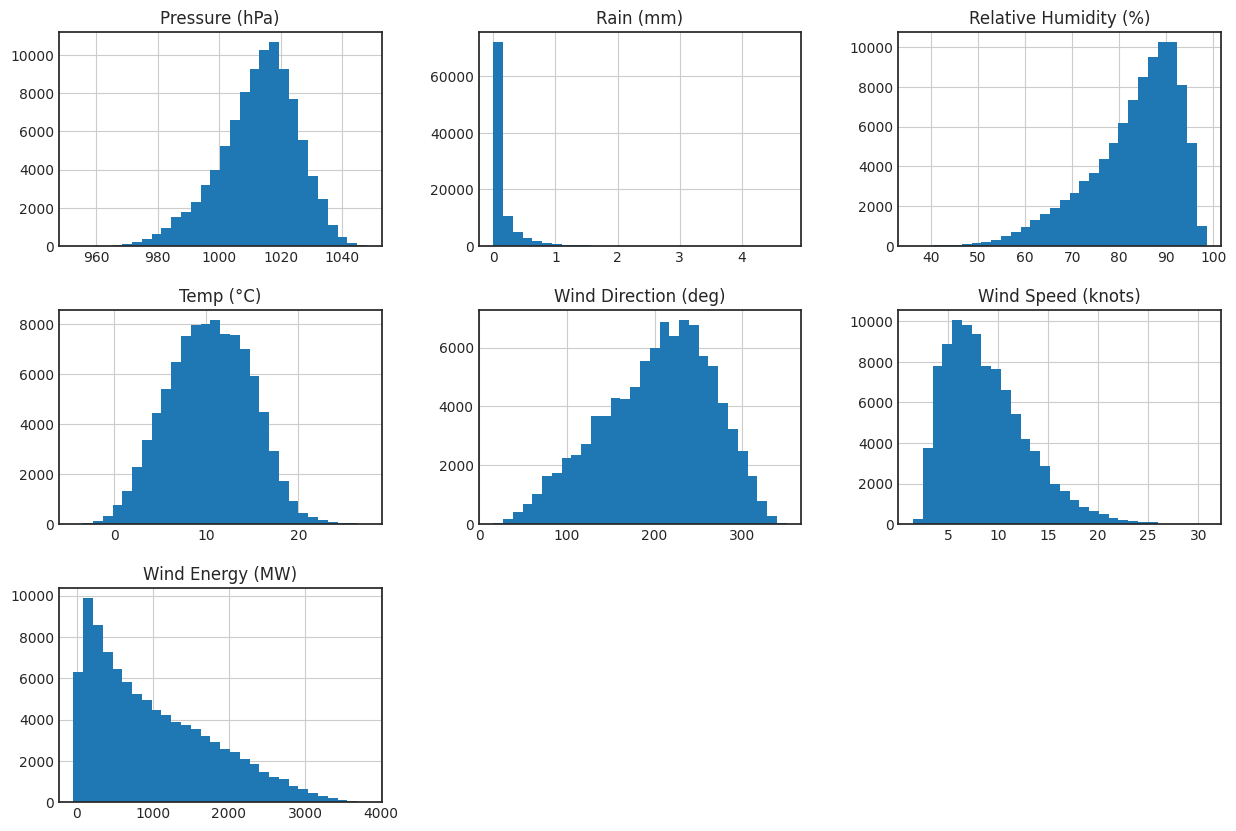

In [15]:
# Plot the distribution of the data with histograms
electricity_weather.hist(figsize= (15,10), bins = 30)

plt.show()

In [16]:
electricity_weather.loc[electricity_weather['Wind Energy (MW)'] < 0]

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW)
date,,,,,,,
2014-10-12 00:00:00,1012.22,0.00,93.92,5.73,147.50,2.00,-0.75
2014-10-12 01:00:00,1012.32,0.00,94.67,5.32,167.50,1.75,-2.50
2014-10-12 02:00:00,1012.32,0.00,95.33,5.13,195.83,2.42,-1.50
2014-10-12 03:00:00,1012.22,0.01,95.67,5.31,215.83,2.42,-1.25
2014-10-12 05:00:00,1012.18,0.02,96.17,4.62,168.33,2.75,-1.00
2014-10-12 06:00:00,1012.27,0.01,97.00,4.33,124.17,2.83,-1.25
2014-10-12 07:00:00,1012.55,0.00,97.00,4.19,195.00,2.75,-1.50
2016-05-16 09:00:00,1023.16,0.00,70.25,11.98,160.00,3.42,-2.25
2016-05-16 10:00:00,1022.94,0.00,68.00,13.02,182.50,3.75,-1.00


In [17]:
count_negative_wind_energy = (electricity_weather['Wind Energy (MW)'] < 0).sum()
count_negative_wind_energy

49

In the histogram for wind energy there values negative values. Wind speeds are low. Using energy and not creating energy. Only 49 rows. 

## Investigate Wind Energy and Wind Speeds

In [ ]:
# Resample weather_df to monthly
electricity_weather_monthly = electricity_weather.resample('ME').mean()
electricity_weather_monthly.head()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW)
date,,,,,,,
2014-01-31,993.884435,0.244140,87.123763,5.875793,211.225417,10.867594,774.699933
2014-02-28,988.311429,0.275074,84.325030,5.749241,212.415804,13.037649,925.433780
2014-03-31,1013.142648,0.122809,84.740054,7.045726,202.654597,9.622581,647.850806
2014-04-30,1012.485083,0.075319,80.475625,9.921472,176.797472,8.629181,493.911111
2014-05-31,1014.004167,0.135013,83.432272,11.358602,200.795336,8.646425,461.017809


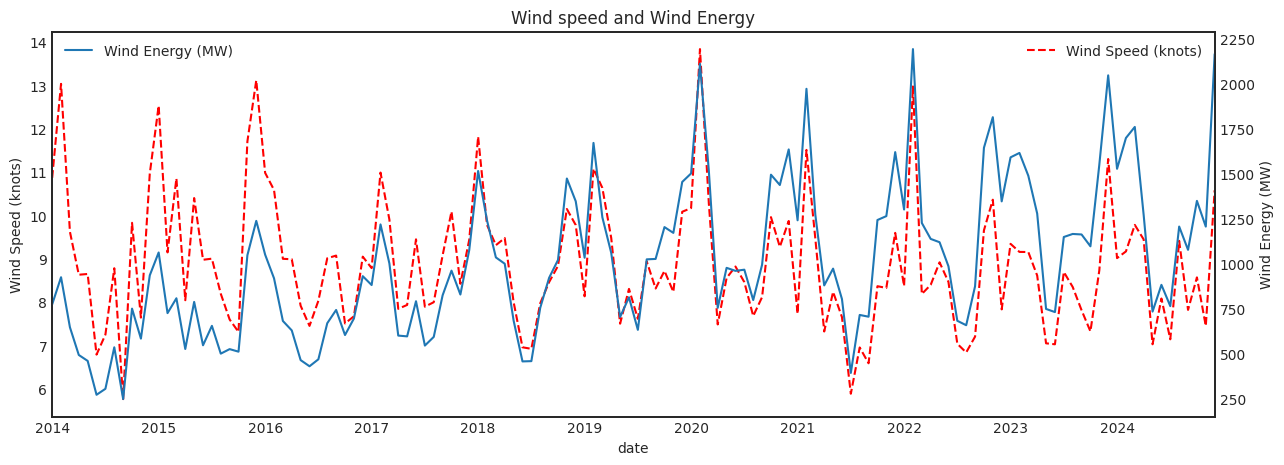

In [19]:
fig, ax = plt.subplots(figsize = (15,5))

electricity_weather_monthly['Wind Speed (knots)'].plot(ax=ax, color = 'red', linestyle = 'dashed', label= 'Wind Speed (knots)')
ax.legend()
plt.ylabel('Wind Speed (knots)')

ax2 = ax.twinx()

electricity_weather_monthly['Wind Energy (MW)'].plot(ax= ax2, label= 'Wind Energy (MW)')
ax2.legend(loc = 'upper left')

plt.title('Wind speed and Wind Energy')
plt.ylabel('Wind Energy (MW)')
plt.show()

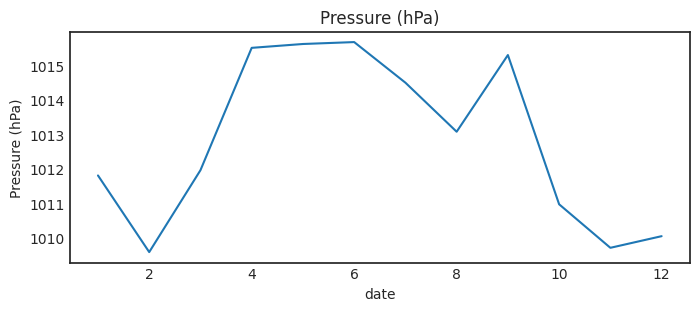

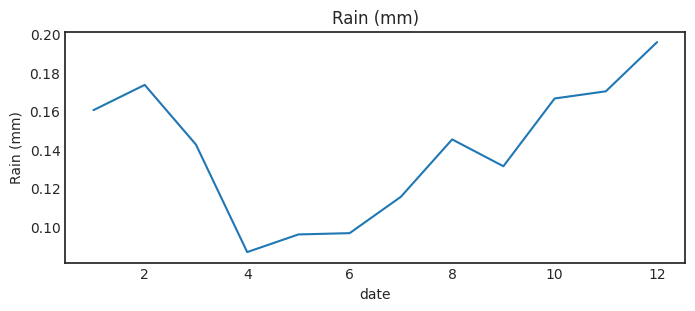

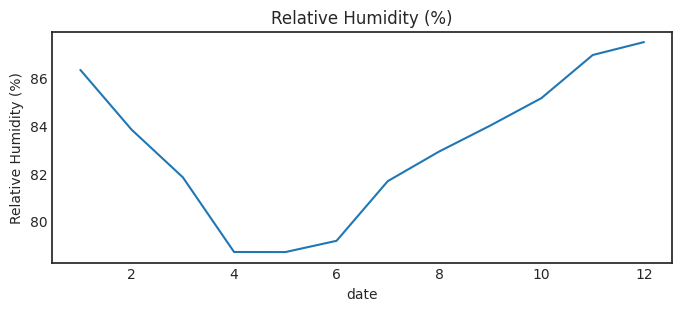

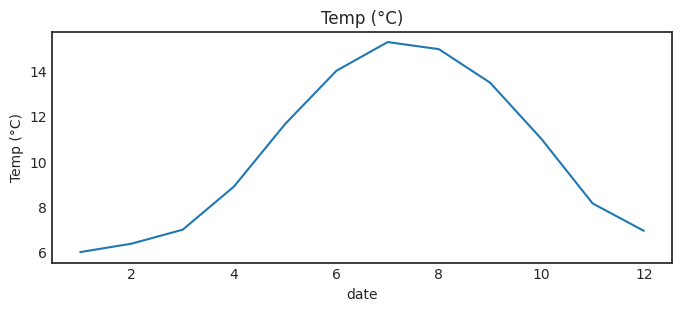

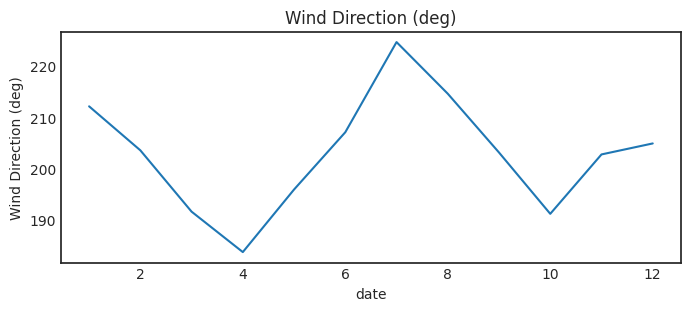

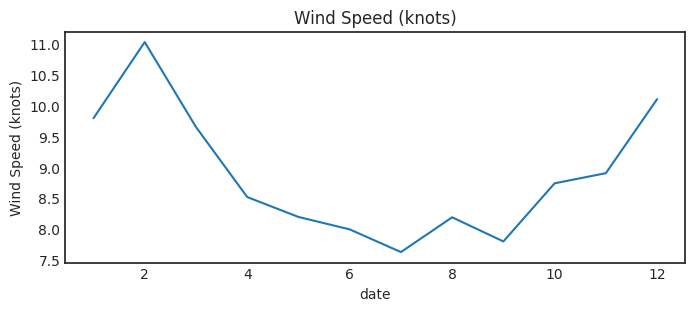

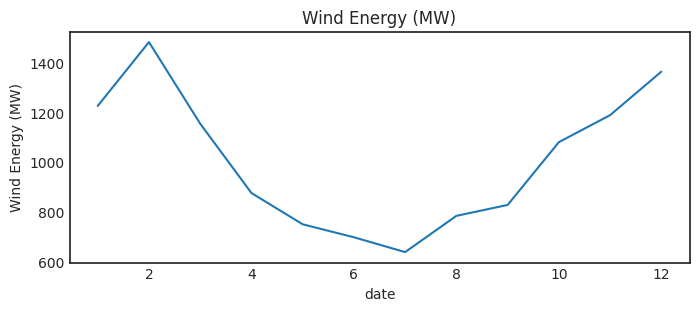

In [20]:
# Monthly Trends in Weather Data
for col in electricity_weather:
    fig, ax = plt.subplots(figsize = (8, 3))
    sns.lineplot(electricity_weather, x = electricity_weather.index.month, y = col, errorbar= None)
    plt.title(f'{col}')
    plt.show()

### Scatter Plots

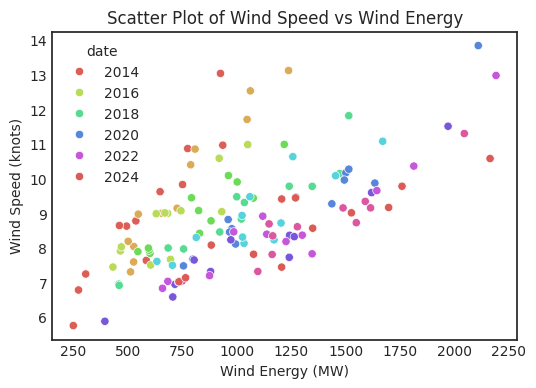

In [21]:
fig, ax = plt.subplots(figsize = (6,4))
sns.scatterplot(data = electricity_weather_monthly, 
                x= 'Wind Energy (MW)', 
                y = 'Wind Speed (knots)', 
                hue= electricity_weather_monthly.index.year,
                palette= 'hls')
plt.title('Scatter Plot of Wind Speed vs Wind Energy')
plt.show()

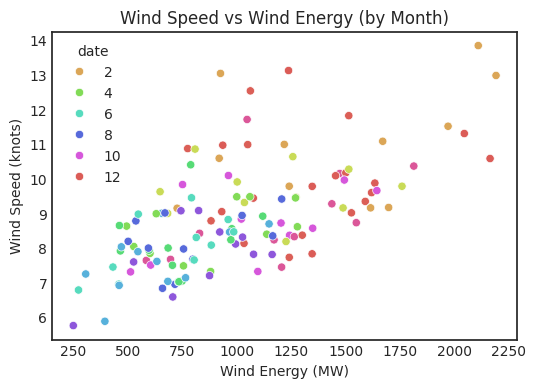

In [22]:
fig, ax = plt.subplots(figsize = (6,4))
sns.scatterplot(data = electricity_weather_monthly, 
                x= 'Wind Energy (MW)', 
                y = 'Wind Speed (knots)', 
                hue= electricity_weather_monthly.index.month,
                palette= 'hls')
plt.title('Wind Speed vs Wind Energy (by Month)')
plt.show()

In [ ]:
electricity_weather_yearly = electricity_weather.resample('YE').mean()
electricity_weather_yearly.head()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW)
date,,,,,,,
2014-12-31,1009.612357,0.143957,83.663824,10.373425,202.467838,8.969831,577.399201
2015-12-31,1014.334927,0.158261,82.578727,9.749906,207.072672,9.750983,746.253796
2016-12-31,1014.133199,0.126036,82.708215,10.061734,197.370263,8.765640,690.754696
2017-12-31,1014.494326,0.131568,83.605372,10.331378,212.948322,8.970461,824.732820
2018-12-31,1012.622820,0.130381,82.380785,10.145533,196.043534,8.948595,991.110859


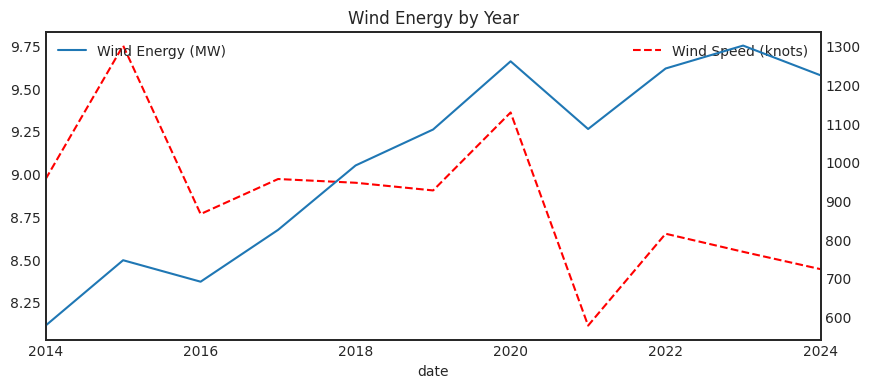

In [24]:
fig, ax = plt.subplots(figsize = (10,4))

electricity_weather_yearly['Wind Speed (knots)'].plot(ax=ax, color = 'red', linestyle = 'dashed', label = 'Wind Speed (knots)')
plt.legend()
ax2 = ax.twinx()

electricity_weather_yearly['Wind Energy (MW)'].plot(ax= ax2, label = 'Wind Energy (MW)')
plt.title('Wind Energy by Year')
plt.legend()
plt.show()


### Correlation

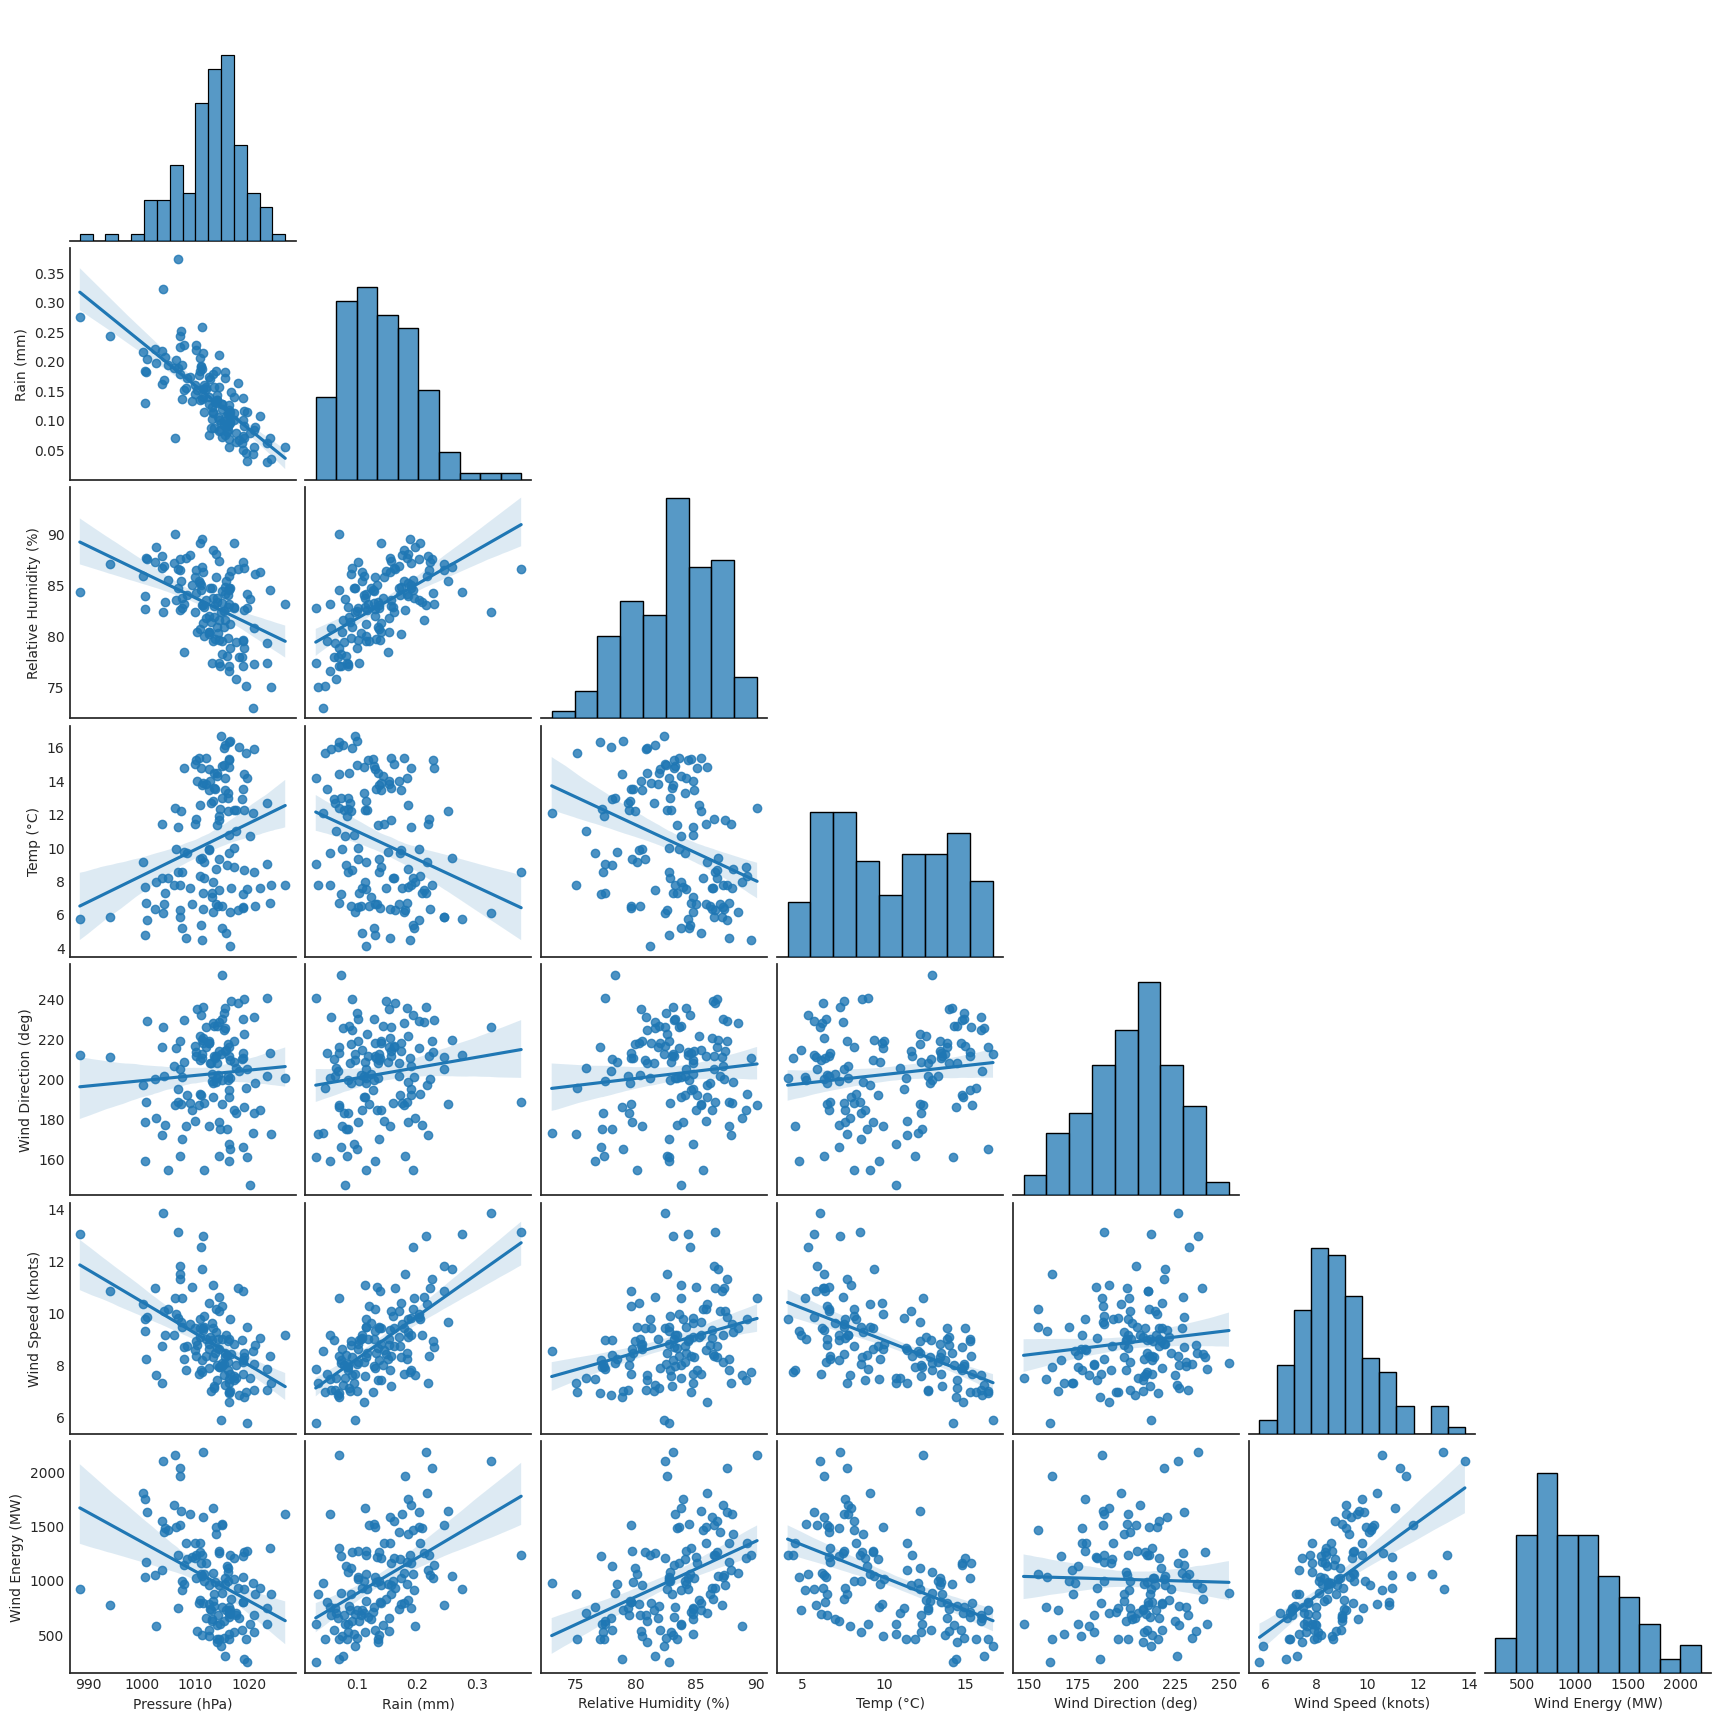

In [25]:
sns.pairplot(data= electricity_weather_monthly, kind= 'reg', corner = True)
plt.show()

In [ ]:
electricity_weather.corr().round(3)

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW)
Pressure (hPa),1.000,-0.396,-0.185,0.105,-0.025,-0.400,-0.358
Rain (mm),-0.396,1.000,0.271,-0.000,-0.072,0.338,0.315
Relative Humidity (%),-0.185,0.271,1.000,-0.290,-0.049,-0.186,0.014
Temp (°C),0.105,-0.000,-0.290,1.000,-0.002,0.048,-0.090
Wind Direction (deg),-0.025,-0.072,-0.049,-0.002,1.000,0.153,0.059
Wind Speed (knots),-0.400,0.338,-0.186,0.048,0.153,1.000,0.798
Wind Energy (MW),-0.358,0.315,0.014,-0.090,0.059,0.798,1.000


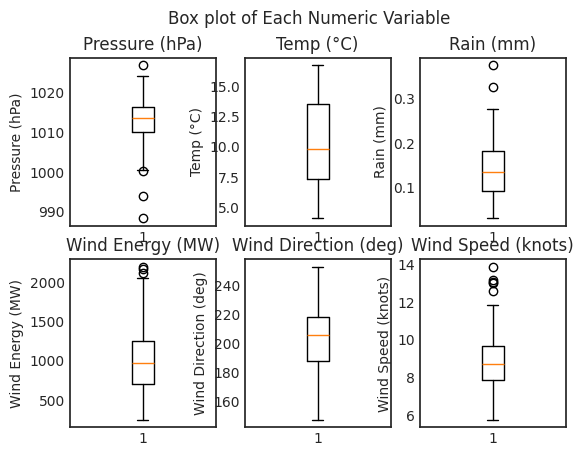

In [27]:

# Overall plot title


fix, ax = plt.subplots(2, 3)

ax[0,0].boxplot(data= electricity_weather_monthly, x = 'Pressure (hPa)')
ax[0,0].set_title('Pressure (hPa)')
ax[0,0].set_ylabel('Pressure (hPa)')


ax[0,1].boxplot(data= electricity_weather_monthly, x = 'Temp (°C)')
ax[0,1].set_title('Temp (°C)')
ax[0,1].set_ylabel('Temp (°C)')


ax[0,2].boxplot(data= electricity_weather_monthly, x = 'Rain (mm)')
ax[0,2].set_title('Rain (mm)')
ax[0,2].set_ylabel('Rain (mm)')


ax[1,0].boxplot(data= electricity_weather_monthly, x = 'Wind Energy (MW)')
ax[1,0].set_title('Wind Energy (MW)')
ax[1,0].set_ylabel('Wind Energy (MW)')


ax[1,1].boxplot(data= electricity_weather_monthly, x = 'Wind Direction (deg)')
ax[1,1].set_title('Wind Direction (deg)')
ax[1,1].set_ylabel('Wind Direction (deg)')

ax[1,2].boxplot(data= electricity_weather_monthly, x = 'Wind Speed (knots)')
ax[1,2].set_title('Wind Speed (knots)')
ax[1,2].set_ylabel('Wind Speed (knots)')

plt.suptitle('Box plot of Each Numeric Variable')
plt.show()

### Weather Trends

See weather_trends.ipynb

### Is there much variation in wind speed across the country? 

Electricity generated is given for ROI not broken down by wind farm.

Electricity data from 2014, so to compare wind speed and amount of electricity generated by wind only need weather data from 2014. 


## Seasonal Analysis

Season analysis. Discuss results from weather_trends. Analysed from 1944. Wind speeds are reducing. 

trend, seasonal residual

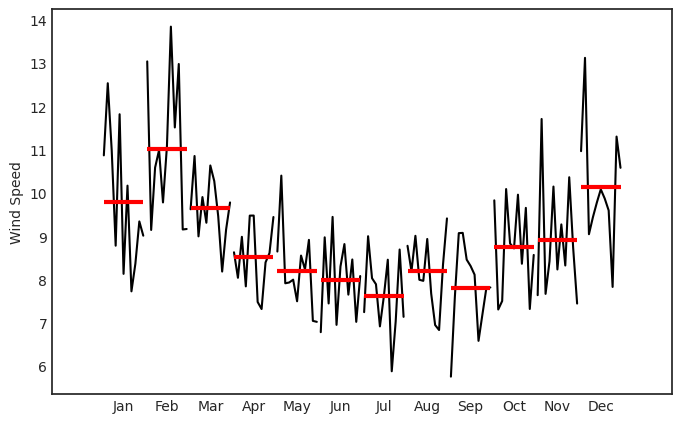

In [28]:
# Seasonality curve. Black is values for each month. Red is the average for that month. 
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

rcParams['figure.figsize'] = 8, 5

month_plot(electricity_weather_monthly['Wind Speed (knots)'], ylabel= 'Wind Speed')
plt.show()

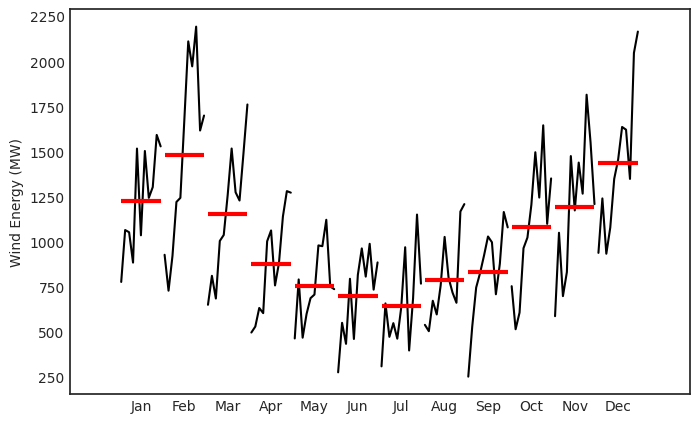

In [29]:
month_plot(electricity_weather_monthly['Wind Energy (MW)'], ylabel= 'Wind Energy (MW)')
plt.show()

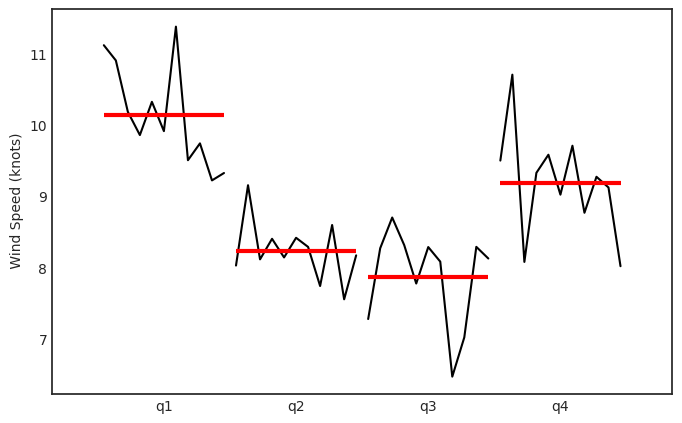

In [30]:
rcParams['figure.figsize'] = 8, 5

quarter_plot(electricity_weather['Wind Speed (knots)'].resample('QE').mean(), ylabel= ' Wind Speed (knots)')
plt.show()

In [31]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
#from statsforecast import StatsForecast
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams

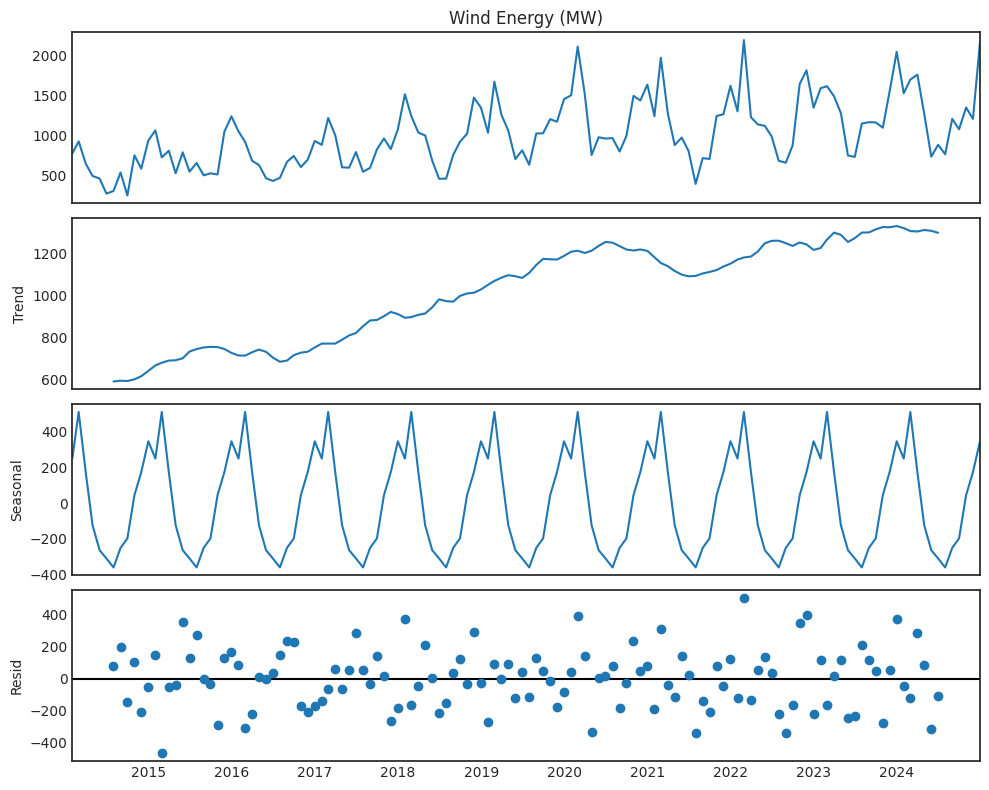

In [32]:
rcParams['figure.figsize'] = 10, 8

decomposition = sm.tsa.seasonal_decompose(electricity_weather_monthly['Wind Energy (MW)'], model= 'additive', period = 12)
fig = decomposition.plot()


## Discussion of the Analysis

nice plots

## Machine Learning

Aim: Can the weather data be used to predict the wind energy?

train
https://stackoverflow.com/questions/74025273/is-train-test-splitshuffle-false-appropriate-for-time-series

sklearn.model_selection.TimeSeriesSplit

https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split TimeSeriesSplit is a variation of k-fold which returns first 
 folds as train set and the (k+1)th fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the model.

In [33]:
X = electricity_weather.drop('Wind Energy (MW)', axis= 1)

In [34]:
y = electricity_weather['Wind Energy (MW)']

In [35]:
print(X.shape, y.shape)

(95689, 6) (95689,)


In [36]:
tss = TimeSeriesSplit(n_splits = 5)

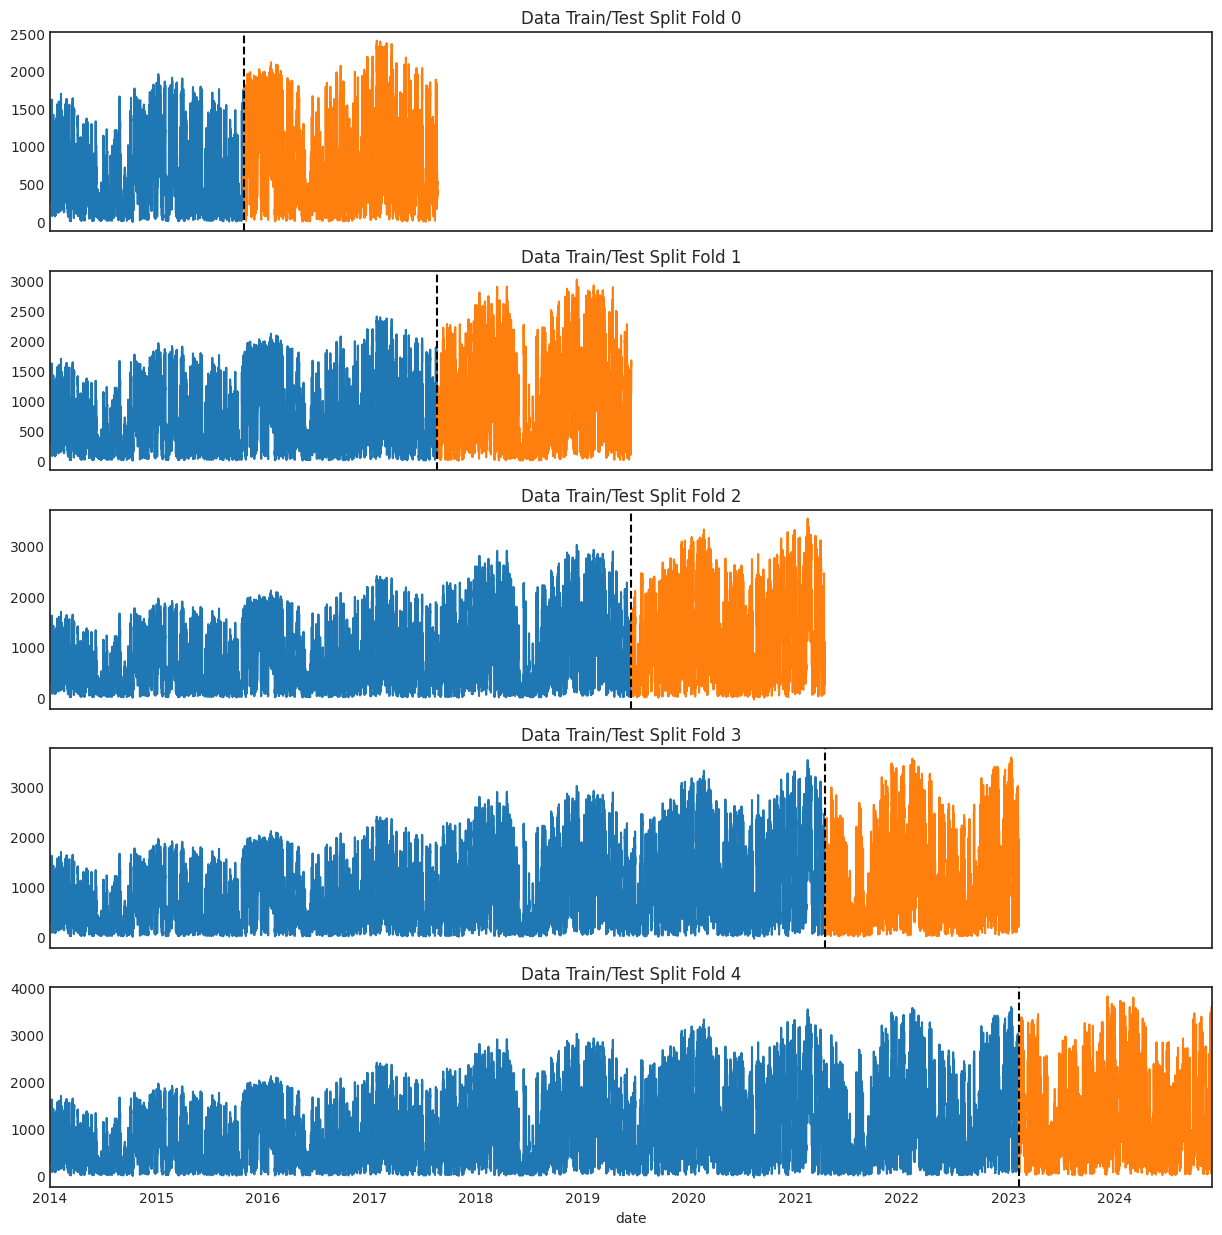

In [37]:
# https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(X):
    train = electricity_weather.iloc[train_idx]
    test = electricity_weather.iloc[val_idx]
    train['Wind Energy (MW)'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Wind Energy (MW)'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

For time series data it is important to keep the data in the order that they happened and train_test_split should not be used to split the data into a training set and test set. Data leakage 
[TimeSeriesSplit](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) module 
https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split


https://medium.com/@Stan_DS/timeseries-split-with-sklearn-tips-8162c83612b9

https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [38]:
from sklearn.tree import DecisionTreeRegressor

predictions = []
scores = []
r_squares = []

for train_idx, val_idx in tss.split(X):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[val_idx, :]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]

    dtr = DecisionTreeRegressor(max_depth = 2)

    dtr.fit(X_train, y_train)

    y_prediction = dtr.predict(X_test)
    predictions.append(y_prediction)


    rmse = root_mean_squared_error(y_test, y_prediction)
    scores.append(rmse)

    r_squared = dtr.score(X_test, y_test)
    r_squares.append(r_squared)

In [39]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 531.3815
Fold scores:[311.7043949654513, 505.63499025214736, 632.6874644969215, 600.3787171117897, 606.5020695042153]


In [40]:
print(f'R_squared across folds {np.mean(r_squares):0.4f}')
print(f'R_squared scores:{r_squares}')

R_squared across folds 0.5518
R_squared scores:[0.7036530725096106, 0.5291511996982332, 0.43945241883520925, 0.5539807522339733, 0.5327622398013734]


Since 2018, electricity generated has been greater than windspeed. Improve model by excluding data before 2018. Could refine this further from the exact date in 2017 where this change 
occurred. 

In [41]:
data_2018_onwards = electricity_weather.loc['2018' : ]
data_2018_onwards.head()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW)
date,,,,,,,
2018-01-01 00:00:00,991.72,0.20,83.92,5.84,240.00,15.00,1970.25
2018-01-01 01:00:00,991.58,0.18,84.08,5.81,240.00,14.17,1874.50
2018-01-01 02:00:00,991.35,0.22,84.58,5.76,235.83,14.25,1675.25
2018-01-01 03:00:00,991.23,0.26,85.67,5.72,235.00,13.17,1368.00
2018-01-01 04:00:00,990.92,0.25,84.92,5.58,239.17,12.08,1327.25


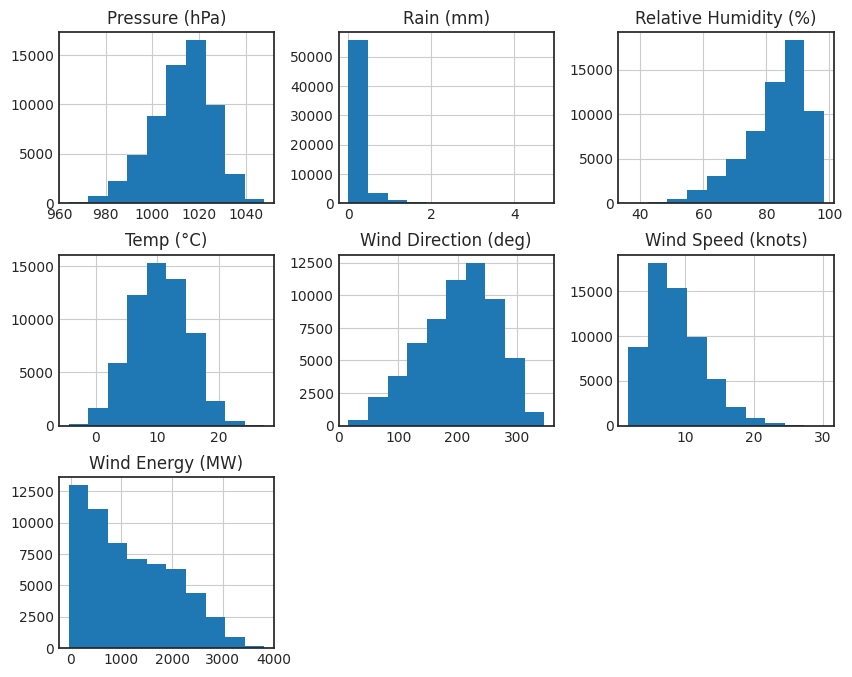

In [42]:
data_2018_onwards.hist()
plt.show()

In [43]:
X = data_2018_onwards.drop('Wind Energy (MW)', axis= 1)
y = data_2018_onwards['Wind Energy (MW)']

In [44]:
predictions = []
scores = []
r_squares = []

for train_idx, val_idx in tss.split(X):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[val_idx, :]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]

    dtr = DecisionTreeRegressor(max_depth = 3)

    dtr.fit(X_train, y_train)

    y_prediction = dtr.predict(X_test)
    predictions.append(y_prediction)


    rmse = root_mean_squared_error(y_test, y_prediction)
    scores.append(rmse)

    r_squared = dtr.score(X_test, y_test)
    r_squares.append(r_squared)

In [45]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 412.5057
Fold scores:[365.7680762627853, 404.12574390047666, 398.04071510998733, 435.73357275534806, 458.8603727458994]


In [46]:
print(f'R_squared across folds {np.mean(r_squares):0.4f}')
print(f'R_squared scores:{r_squares}')

R_squared across folds 0.7751
R_squared scores:[0.7991673596246944, 0.7713787917989916, 0.7951828313745297, 0.7654175881867925, 0.7444226365812574]


In [47]:
print("Predictions: {},\nActual Values: {}".format(y_prediction[:5], y_test[:5]))

Predictions: [1745.74855243 1094.63296108 1094.63296108 1094.63296108 1094.63296108],
Actual Values: date
2023-10-07 01:00:00    1571.50
2023-10-07 02:00:00    1570.00
2023-10-07 03:00:00    1379.50
2023-10-07 04:00:00    1335.25
2023-10-07 05:00:00    1420.00
Freq: h, Name: Wind Energy (MW), dtype: float64


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.03831
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.96169


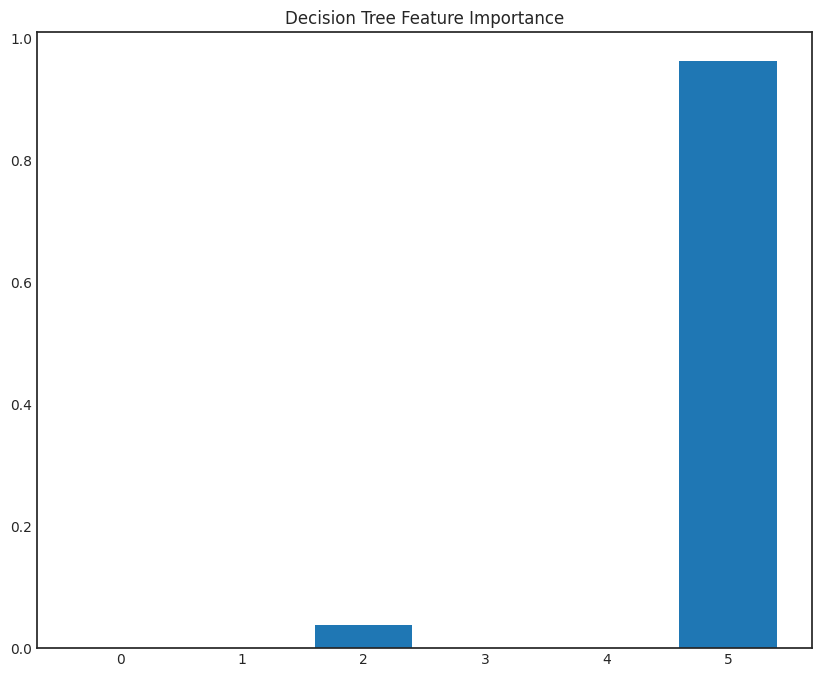

In [48]:
importance = dtr.feature_importances_

for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')
plt.bar([x for x in range(len(importance))], importance)
plt.title('Decision Tree Feature Importance')
plt.show()

# https://www.geeksforgeeks.org/understanding-feature-importance-and-visualization-of-tree-models/

Cross-validation
dependent on way the data is split.


Discuss feature importance.

Decision tree is visualized using the plot_tree function. 

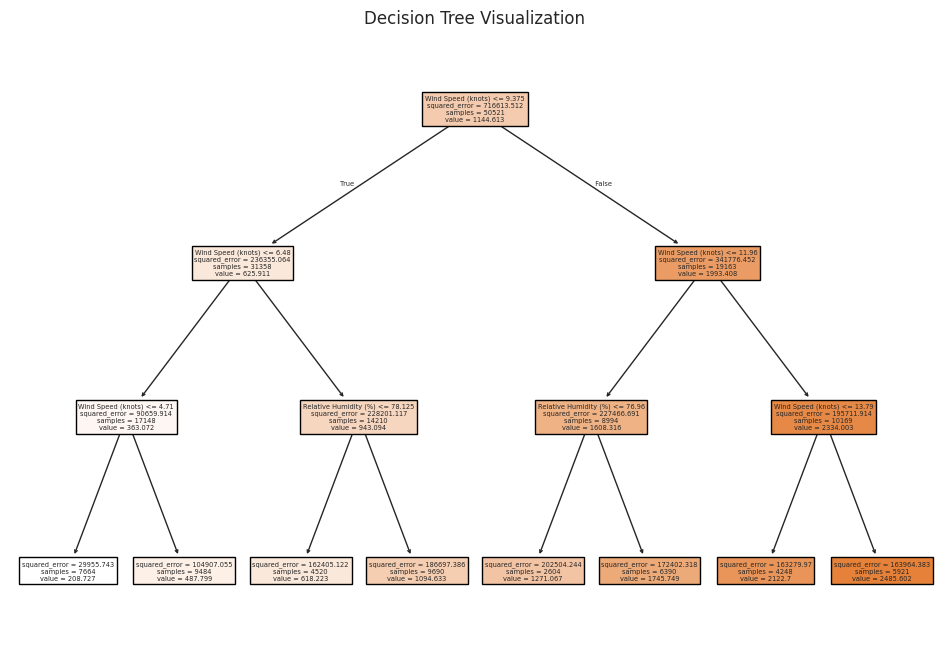

In [49]:
# https://scikit-learn.org/1.5/modules/generated/sklearn.tree.plot_tree.html
# https://www.geeksforgeeks.org/understanding-feature-importance-and-visualization-of-tree-models/


from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(dtr, filled=True, feature_names= X_train.columns, class_names= y_train)
plt.title('Decision Tree Visualization')
plt.show()

https://github.com/Pitsillides91/Python-Tutorial-2022-/blob/main/Linear%20Regression%20Example/Linear%20Regression%20Tutorial%202022%20-%20Full%20Code.ipynb


https://www.youtube.com/watch?v=9QtL7m3YS9I Kishan Manani - Feature Engineering for Time Series Forecasting | PyData London 2022

Decision tree regression

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet

When should you not normalise in machine learning https://stackoverflow.com/questions/49543049/scaling-features-for-prediction-in-scikit-learn?rq=3

https://stackoverflow.com/questions/49543049/scaling-features-for-prediction-in-scikit-learn?rq=3

rom sklearn.preprocessing import MinMaxScaler

pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', SVR())]) 
time_split = TimeSeriesSplit(n_splits=5) 
param_grid = {'clf__kernel': ['rbf'], 
          'clf__C':[0.0001, 0.001], 
          'clf__gamma': [0.0001, 0.001]} 

grid = GridSearchCV(pipe, param_grid, cv= time_split, 
       scoring='neg_mean_squared_error', n_jobs = -1) 
grid.fit(X_train, y_train)

# Pickle the data with a content manager
with open('Pickles/{}.pkl'.format(file_name), 'wb') as file:
    pickle.dump(grid, file)

# Load Pickle with a content manager
with open('Pickles/{}.pkl'.format(file_name), 'rb') as file:
    model = pickle.load(file)


model.predict(new_data_scaled)

Elastic Net regression https://www.youtube.com/watch?v=1dKRdX9bfIo

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, shuffle=False)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

0.7584334051536971


In [51]:
reg = LinearRegression()

reg.fit(X_train, y_train)
y_predictions = reg.predict(X_test)

# Calculate R-squared, default metric for linear regression, value between 0 and 1
r_squared = reg.score(X_test, y_test)

print(f'R squared: {r_squared}')

# Root Mean squared error, measured in units of target variable squared. 
rmse = root_mean_squared_error(y_test, y_predictions)

print(f'RMSE: {rmse}')

from sklearn.metrics import r2_score

score = r2_score(y_test, y_predictions)
print(score)

R squared: 0.7584334871609206
RMSE: 441.58012151674905
0.7584334871609206


In [52]:
from sklearn import linear_model

ENreg = linear_model.ElasticNet(alpha = 0.1)
ENreg.fit(X_train, y_train)
y_pred = ENreg.predict(X_test)

r_2 = ENreg.score(X_test, y_test)
r_2



0.7580144589249108

## Forecasting

Predict wind energy for the next 4 weeks

Resample the data by week



In [53]:
electricity_weather_weekly = electricity_weather.resample('W').mean()
electricity_weather_weekly.head()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW)
date,,,,,,,
2014-01-05,981.688250,0.279833,85.699000,5.875667,198.610667,12.895833,948.806250
2014-01-12,1000.566964,0.208274,87.112440,6.125952,200.878512,10.759821,770.965774
2014-01-19,989.108810,0.156250,90.518631,5.101607,201.225179,7.054643,424.248512
2014-01-26,1003.922976,0.298631,85.699286,6.752917,228.373036,12.373810,941.940476
2014-02-02,987.807917,0.300238,84.535595,5.553155,226.255060,13.818988,994.949405


In [54]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

electricity_weather_monthly['TESmul12'] = ExponentialSmoothing(electricity_weather_monthly['Wind Energy (MW)'], trend= 'mul', seasonal= 'mul', seasonal_periods= 12).fit().fittedvalues
electricity_weather_monthly.head()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW),TESmul12
date,,,,,,,,
2014-01-31,993.884435,0.244140,87.123763,5.875793,211.225417,10.867594,774.699933,850.384912
2014-02-28,988.311429,0.275074,84.325030,5.749241,212.415804,13.037649,925.433780,779.327651
2014-03-31,1013.142648,0.122809,84.740054,7.045726,202.654597,9.622581,647.850806,692.240863
2014-04-30,1012.485083,0.075319,80.475625,9.921472,176.797472,8.629181,493.911111,537.923361
2014-05-31,1014.004167,0.135013,83.432272,11.358602,200.795336,8.646425,461.017809,509.041373


In [55]:
electricity_weather_monthly['TESadd12'] = ExponentialSmoothing(electricity_weather_monthly['Wind Energy (MW)'], trend= 'add', seasonal= 'add', seasonal_periods= 7).fit().fittedvalues
electricity_weather_monthly.head()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW),TESmul12,TESadd12
date,,,,,,,,,
2014-01-31,993.884435,0.244140,87.123763,5.875793,211.225417,10.867594,774.699933,850.384912,371.362466
2014-02-28,988.311429,0.275074,84.325030,5.749241,212.415804,13.037649,925.433780,779.327651,701.010684
2014-03-31,1013.142648,0.122809,84.740054,7.045726,202.654597,9.622581,647.850806,692.240863,1053.048934
2014-04-30,1012.485083,0.075319,80.475625,9.921472,176.797472,8.629181,493.911111,537.923361,685.035854
2014-05-31,1014.004167,0.135013,83.432272,11.358602,200.795336,8.646425,461.017809,509.041373,549.404044


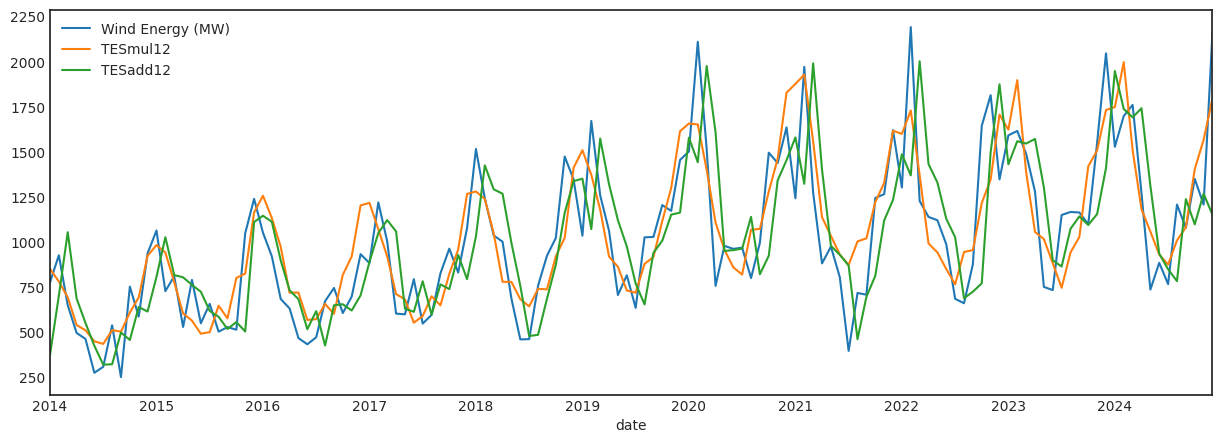

In [56]:
electricity_weather_monthly[['Wind Energy (MW)', 'TESmul12', 'TESadd12']].plot(figsize = (15,5))
plt.show()

### Building Forecasting Model

In [71]:
train_data = electricity_weather_monthly.iloc[:105]
train_data.tail()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW),TESmul12,TESadd12
date,,,,,,,,,
2022-05-31,1016.039462,0.090269,79.889718,12.200081,217.908831,8.915941,1119.702621,941.253235,1329.042324
2022-06-30,1013.658000,0.132208,79.760944,13.508167,210.671319,8.463111,986.389583,849.084202,1127.871316
2022-07-31,1020.932554,0.056196,80.869637,15.922755,231.394153,7.034059,683.578965,764.002040,1025.757148
2022-08-31,1018.164234,0.068065,77.941720,16.012070,204.429906,6.833858,659.016129,943.398460,686.596007
2022-09-30,1013.521278,0.156722,82.980403,13.552931,211.871472,7.199708,875.273958,953.809262,723.073428


In [72]:
test_data = electricity_weather_monthly.iloc[105:]
test_data.head()

,Pressure (hPa),Rain (mm),Relative Humidity (%),Temp (°C),Wind Direction (deg),Wind Speed (knots),Wind Energy (MW),TESmul12,TESadd12
date,,,,,,,,,
2022-10-31,1007.342581,0.252003,85.435645,12.211022,187.829247,9.655121,1643.985551,1215.403486,769.591352
2022-11-30,1000.081611,0.216736,85.898792,9.182292,197.166569,10.362319,1813.817361,1345.728745,1496.771865
2022-12-31,1008.167715,0.154812,87.706196,4.587298,177.023898,7.829032,1346.522849,1706.012048,1874.104396
2023-01-31,1011.372137,0.154395,86.325524,6.333038,220.655430,9.342446,1590.782594,1622.510466,1430.033458
2023-02-28,1026.851920,0.054911,83.222113,7.796845,201.020685,9.156071,1615.236421,1897.207349,1558.143902


In [73]:
fitted_model = ExponentialSmoothing(train_data['Wind Energy (MW)'], trend = 'add',seasonal= 'add', seasonal_periods=12 ).fit()

In [83]:
test_predictions = fitted_model.forecast(27).rename('Wind Energy Forecast')
len(test_predictions)

27

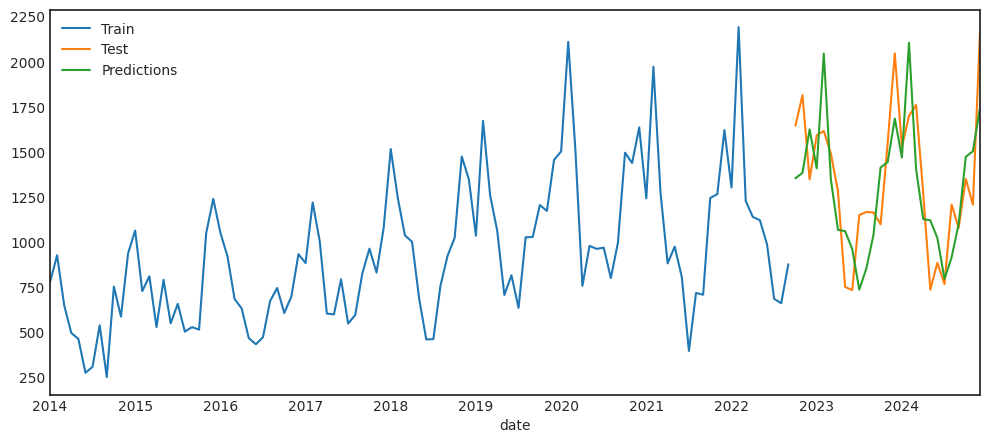

In [80]:
train_data['Wind Energy (MW)'].plot(legend = True, label = 'Train', figsize= (12, 5))
test_data['Wind Energy (MW)'].plot(legend= True, label = 'Test')
test_predictions.plot(legend= True, label = 'Predictions')
plt.show()

Evaluation Metrics

In [88]:
r2_score(test_data['Wind Energy (MW)'],test_predictions)

0.4518333585125436

In [87]:
RMSE = root_mean_squared_error(test_data['Wind Energy (MW)'],test_predictions)

282.5815531356476

In [90]:
test_data['Wind Energy (MW)'].describe()

count      27.000000
mean     1335.947859
std       388.940094
min       731.967708
25%      1122.858535
50%      1278.794444
75%      1603.009508
max      2164.250000
Name: Wind Energy (MW), dtype: float64

In [91]:
final_model = ExponentialSmoothing(electricity_weather_monthly['Wind Energy (MW)'], trend = 'add', seasonal= 'add', seasonal_periods= 12).fit()

In [99]:
forecast_predictions = final_model.forecast(10)

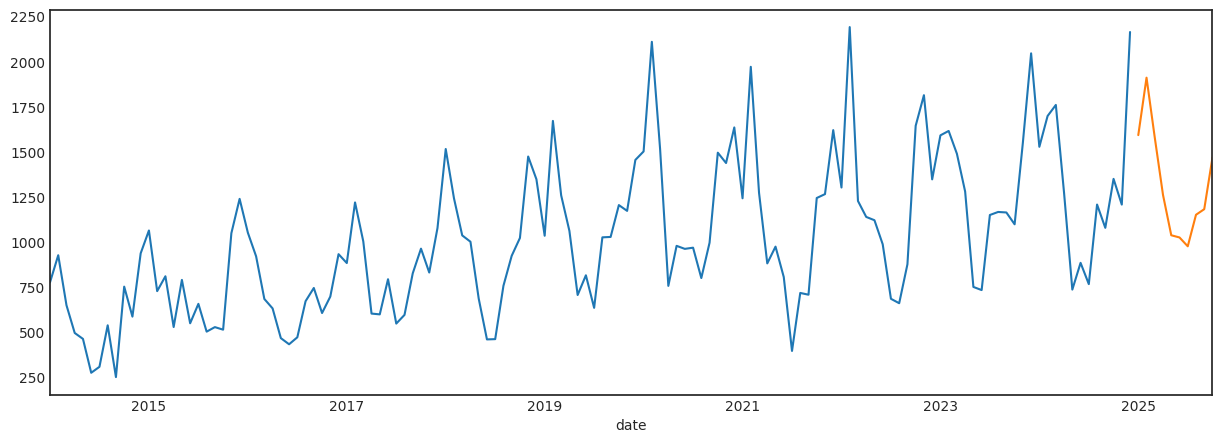

In [100]:
electricity_weather_monthly['Wind Energy (MW)'].plot(figsize=(15, 5))
forecast_predictions.plot()
plt.show()

Messing around with darts

https://realpython.com/linear-regression-in-python/

https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression

## Conclusion



## References


http://www.iwea.ie/technicalfaqs


### Data Sets

[GitHub Daniel Parke]https://github.com/Daniel-Parke/EirGrid_Data_Download/tree/main


__Problems that arose__

[Git LFS (large file storage)](https://git-lfs.com/). Some of the weather data filew were larger than GitHub's recommended maximum file size of 50.00 MB. Installed and used Git lfs


https://mljar.com/blog/matplotlib-colors/
